<a href="https://colab.research.google.com/github/abd-mo/Image-Classifier-by-pytorch/blob/master/PyTorchFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
import numpy as np

import helper
import matplotlib.pyplot as plt
from PIL import Image ## image proccessing 
from torch import optim,nn ## create our neural network layers
from torchvision import datasets,models,transforms #import data
from torch.autograd import variable
from torch.optim import lr_scheduler
import time
import copy
import json
import seaborn as sns
from google.colab import drive
from collections import OrderedDict


In [0]:

!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
dirs = {'train': train_dir, 
        'valid': valid_dir}
image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [0]:
with open('cat_to_name.json', 'r') as f:
    label_map = json.load(f)
    print(label_map)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [0]:
model = models.vgg19(pretrained=True)

In [0]:
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
for param in model.parameters():
    param.requires_grad = False
model.classifier = classifier

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
def train_model(model, criteria, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            model = model.to(device)
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl


5.3.0


In [0]:
# Criteria NLLLoss which is recommended with Softmax final layer
criteria = nn.NLLLoss()
# Observe that all parameters are being optimized
opt = optim.Adam(model.classifier.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 4 epochs
sched = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
# Number of epochs
eps=15
model_ft = train_model(model, criteria, opt, sched, eps)

Epoch 0/14
----------
train Loss: 2.3999 Acc: 0.4638
valid Loss: 0.9243 Acc: 0.7384

Epoch 1/14
----------
train Loss: 1.1519 Acc: 0.6854
valid Loss: 0.6711 Acc: 0.8203

Epoch 2/14
----------
train Loss: 0.9492 Acc: 0.7340
valid Loss: 0.7570 Acc: 0.7971

Epoch 3/14
----------
train Loss: 0.8703 Acc: 0.7659
valid Loss: 0.6569 Acc: 0.8325

Epoch 4/14
----------
train Loss: 0.8040 Acc: 0.7778
valid Loss: 0.5582 Acc: 0.8533

Epoch 5/14
----------
train Loss: 0.7980 Acc: 0.7840
valid Loss: 0.6464 Acc: 0.8350

Epoch 6/14
----------
train Loss: 0.7341 Acc: 0.8001
valid Loss: 0.6139 Acc: 0.8447

Epoch 7/14
----------
train Loss: 0.5777 Acc: 0.8411
valid Loss: 0.4021 Acc: 0.8985

Epoch 8/14
----------
train Loss: 0.4980 Acc: 0.8608
valid Loss: 0.3778 Acc: 0.9071

Epoch 9/14
----------
train Loss: 0.4630 Acc: 0.8726
valid Loss: 0.3731 Acc: 0.9120

Epoch 10/14
----------
train Loss: 0.4481 Acc: 0.8735
valid Loss: 0.3578 Acc: 0.9095

Epoch 11/14
----------
train Loss: 0.4004 Acc: 0.8883
valid Loss

In [0]:
def calc_accuracy(model, data):
    model.eval()
    model.to(device)    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders[data]):
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            # obtain the outputs from the model
            outputs = model.forward(inputs)
            outputs = outputs.to(device)
            # max provides the (maximum probability, max value)
            _, predicted = outputs.max(dim=1)
            # check the 
            if idx == 0:
                print(predicted) #the predicted class
                print(torch.exp(_)) # the predicted probability
            equals = predicted == labels.data
            if idx == 0:
                print(equals)
            print(equals.float().mean())
            

In [0]:
calc_accuracy(model, "valid")

tensor([ 82,  26,  37,  11,  99,  89,  97,  76,  49,  96,   3,  50, 100,  46,
         49,  13,  90,  49,  49,  94,  12,  45,  90,  85,  75,  64,  24,  83,
         41,  40,  43,  81], device='cuda:0')
tensor([0.9919, 0.7255, 1.0000, 0.5988, 0.8639, 0.9996, 0.9991, 0.9643, 1.0000,
        0.9988, 0.9997, 1.0000, 0.9999, 1.0000, 0.9359, 0.9994, 1.0000, 0.6139,
        0.9942, 0.9999, 0.9814, 0.9964, 0.7463, 0.8679, 1.0000, 0.9665, 1.0000,
        0.6930, 1.0000, 0.6605, 1.0000, 0.9999], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0', dtype=torch.uint8)
tensor(0.9375, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.8438, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.8438, device='

In [0]:
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({'arch': 'vgg19',
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx}, 
            'classifier.pth')

In [0]:
def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    if chpt['arch'] == 'vgg19':
        model = models.vgg19(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Sorry base architecture note recognized")
        return 
    
    model.class_to_idx = chpt['class_to_idx']
    
    # Create the classifier
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    # Put the classifier on the pretrained network
    model.classifier = classifier
    
    model.load_state_dict(chpt['state_dict'])
    
    return model

In [0]:
model = load_model('classifier.pth')
calc_accuracy(model, 'valid')

tensor([  5,  11,  86,  92,  14, 100,  25,  38,  61,   6,  48,  23,  57,  46,
         26,  45,  79,   4,  28,  41,  69,  48,   3,  78,  28,  26,  56,  45,
         41,  14,  50,  83], device='cuda:0')
tensor([0.9989, 1.0000, 0.9930, 1.0000, 1.0000, 0.9964, 0.3315, 1.0000, 0.9998,
        1.0000, 0.9975, 0.9922, 1.0000, 1.0000, 0.9999, 1.0000, 0.9818, 1.0000,
        0.9718, 1.0000, 0.6825, 0.9995, 0.4822, 1.0000, 0.8109, 0.9946, 1.0000,
        0.9964, 0.9932, 1.0000, 0.9999, 0.9983], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.uint8)
tensor(0.9062, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.9375, device='

In [0]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

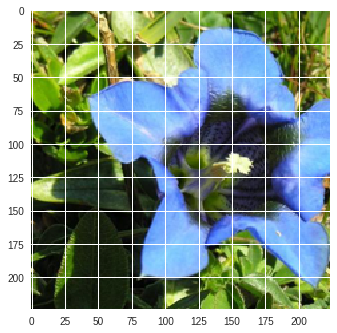

In [0]:
image_path = './flower_data/valid/28/image_05265.jpg'
img = process_image(image_path)
imshow(img)

In [0]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    if torch.cuda.is_available():
      model_input = model_input.cuda()
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().cpu().numpy().tolist()[0] 
    top_labs = top_labs.detach().cpu().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [label_map[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

In [0]:
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[3]
    title_ = label_map[flower_num]
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


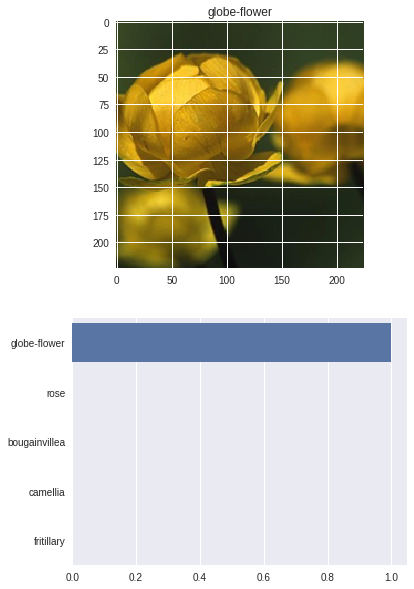

In [0]:
image_path = './flower_data/valid/16/image_06671.jpg'
plot_solution(image_path, model)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


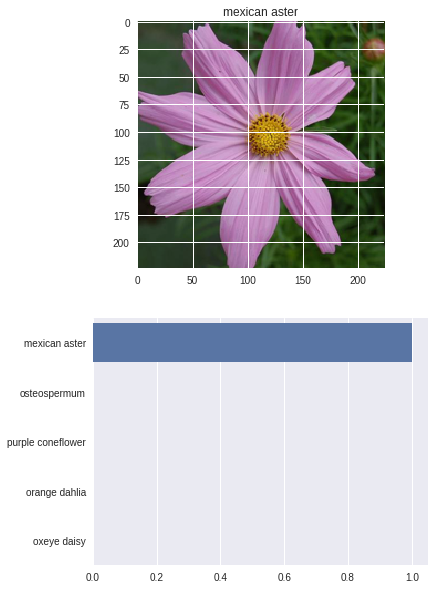

In [0]:
image_path = './flower_data/valid/34/image_06959.jpg'
plot_solution(image_path, model)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)